**项目介绍**
**背景介绍**
信用贷（原蚂蚁借呗）是支付宝平台提供的小额信用贷款服务。互联网小额信用贷款平台（简称网贷平台）根据风险控制和准入标准对支付宝实名用户进行筛选，为筛选出的优质客户提供不同的借款额度。网贷平台的快速发展得益于互联网平台建立了自建的场景流量信用评分体系，形成了获客和贷款的闭环体验。

项目来自于国内网络借贷行业的贷款风险数据，包括：
1.信用违约标签（因变量）
2.建模所需的基础与加⼯字段（自变量）
3.相关用户的网络行为原始数据
本着保护借款⼈隐私以及知识产权的目的，数据字段已经过脱敏处理。

**数据简介**
1.数据编码为GBK。
2.数据包括3万条训练集和3万条测试集。
3.所有训练集(含Training)，测试集(含Test)都包括3个csv文件。

**数据信息**
Master (信贷客户的申报信息和部分第三方数据，以及需要预测的目标标签target。每一行代表一笔借据，即一条成交借款样本，每个样本包含200多个字段)
1.idx：每笔借款的unique key，可与另外2个文件里的idx相匹配
2.UserInfo_*：借款人特征字段
3.WeblogInfo_*：网络行为字段
4.Education_Info*：学历学籍字段
5.ThirdParty_Info_PeriodN_*：第三方数据时间段N字段
6.SocialNetwork_*：社交网络字段
7.LinstingInfo：借款成交时间
8.Target：违约标签（1 = 贷款违约，0 = 正常还款）。测试集里不包含target字段。

Log_Info（信贷客户在网贷平台上的登陆记录）
1.ListingInfo：借款成交时间
2.LogInfo1：操作代码
3.LogInfo2：操作类别
4.LogInfo3：登陆时间
5.idx：每一笔借款的unique key

Userupdate_Info（部分客户在网贷平台上的修改记录）
1.ListingInfo1：借款成交时间
2.UserupdateInfo1：修改内容
3.UserupdateInfo2：修改时间
4.idx：每⼀笔借款的unique key

**案例总体思路**
**数据清洗与预处理**
对缺失值的多维度的处理
对离群点的剔除方法
对变量进行归一化处理（文本处理）

**特征工程**
地理位置信息
成交时间
类别编码
组合特征

**特征选择**
特征相关性
特征重要度排序

**类别不平衡处理**
代价敏感学习与过采样

**模型设计与优化**
逻辑回归
XGBoost
LightGBM
模型融合

**案例流程**

**数据清洗**
**缺失值的多维度处理；**
对于每一列来说，统计每一列的数据缺失比例：
对于每一行来说，也统计一下缺失值的个数并按缺失值大小从小到大排序，训练集和测试集是否表现出近乎一样的分布？如略有不同，是否这部分数据可以认为是离群点？
还可以利用Xgboost在原始的训练集上训练得出每一个原始特征的重要程度列表，排序以后，取前n个重要的原始特征（根据原始特征的数量，可以调整抽取重要特征的个数），然后将有缺失值的样本拿出来进行统计分析。举例：如果其缺失的原始特征中有10个特征都是前20个重要特征，说明这个样本为异常值，可以剔除掉。

**剔除常变量**
原始数据中有190维数值型特征，计算出这些数值型特征的标准差，标准差几乎为零的特征说明在这一维度上的取值几乎为常数，故其没有区分度。可以设置一个阈值，剔除掉标准差小于某个阈值的特征项。

**变量的归一化（文本处理）**
字符大小写转换
比如，Userupdate_Info表中的UserupdateInfo1字段，属性取值为英文字符，包含了大小写，如“_QQ”和“_qQ”，很明显是同一种取值，可以将所有字符统一转换为小写。

空格符号处理
比如，Master表中UserInfo_9字段的取值包含了空格字符，如“中国移动”和“中国移动 ”，它们是同一种取值，需要将空格符去除。

城市名处理
比如，UserInfo_8包含有“重庆”、“重庆市”等取值，它们实际上是同一个城市，需要把字符中的“市”全部去掉。去掉“市”之后，城市数由 600 多下降到 400 多。

**特征工程**
（省份）地理位置的处理方法举例
UserInfo_7和UserInfo_19是省份信息，其余为城市信息。统计每个省份和城市的违约率。
选择违约率超过某个阈值的省份或直辖市，例如四川，湖南，湖北，吉林，天津，山东等等，用这些省份或直辖市构造几个二值特征：“是否为四川省”，“是否为湖南省”........“是否为山东省”，取值为 0或1 。

（市级）地理位置处理方法举例
（1）按照城市等级合并
由于市级城市数量过多，如果按照类别型特征直接处理，进行独热编码后，会得到很高维度的稀疏特征，这样训练的时候，每一维度的城市特征是学不到什么有用的权重的。故不可采取这种办法，除了上述按违约率较高的省份或直辖市单独成为一个维度，违约率过低的合并成一个维度以外，还可以将所有城市按照经济等级分层划分成不同的层次，这样既科学，也能很好的降低城市这一特征维度。具体操作如下，例如一线城市北京，上海，广州，深圳合并，赋值为1，同样的，二线城市合并为2，三线城市合并为3，以此类推。
（2）经纬度特征的引入
上述几种对地理位置信息的处理都是基于类别型的，我们还可以把类别型特征转化为数值型特征，通过引入经纬度来实现。比如，将地理位置特征变为经度和纬度两个特征，北京市可以用经度39.92，纬度116.46，两个特征替换。
（3）构建地理位置的组合特征（地理位置差异特征）
比如，UserInfo_2,UserInfo_4,UserInfo_7,UserInfo_8,UserInfo_20等都是城市地理信息，可以两两比较，构造diff_24(UserInfo_2，UserInfo_4)，当这两个特征值一样时，diff_12为1，否则为0。

以上几种对地理位置的处理方法，可以根据效果选择最适合的方法。

成交时间
（1）将成交时间字段Listinginfo处理成数值型的特征，直接当成连续值来处理。
（2）将成交时间离散化，按照一定的间隔（如以10天为一个区间），即将日期0-10离散为1，日期11-20离散为2，以此类推。

其他特征
UpadteInfo表特征
根据这个表提供的信息，可以从中抽取用户修改信息次数，修改信息时间到成交时间的跨度，每种信息的修改次数等等特征，至于提取的哪个特征具有区别性可以做简单的统计分析，比如每种特征下违约率的分布是否由于不同的取值发生明显的变化。

LogInfo表特征
从登录信息表里可以提取用户的登录信息特征，比如登录天数，平均登录间隔，以及每一种操作代码次数等等特征。

**特征选择**
除了课上讲的一些特征相关性分析方法外，比较高效的一种方法是基于模型的特征排序方法。这种方法有一个好处：模型学习的过程和特征选择的过程是同时进行的，比如基于 xgboost 来做特征选择，xgboost模型训练完成后可以输出特征的重要性，据此可以保留 TopN个特征，从而也可以达到特征选择的目的。

**类别不平衡问题**
赛题数据的类别比例接近13:1，可以尝试采用两种解决类别不平衡问题的方法，代价敏感学习和过采样。分析本案例适用哪种方法。

**建模与模型融合**
Logistic regression + L1正则化
randomforest
Xgboost + bagging
LightGBM
多模型blending（模型融合）

**方案实现**
工具库引入与数据读取

In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [58]:
dataset_path = r'./data/train/'
test_path = r'./data/test/'

train_master = pd.read_csv(os.path.join(dataset_path, 'Master_Training_Set.csv'), encoding='gbk')
train_userupdateinfo = pd.read_csv(os.path.join(dataset_path, 'Userupdate_Info_Training_Set.csv'), encoding='gbk')
train_loginfo = pd.read_csv(os.path.join(dataset_path, 'LogInfo_Training_Set.csv'), encoding='gbk')
train_master['source'] = 'train'
train_userupdateinfo['source'] = 'train'
train_loginfo['source'] = 'train'

test_master = pd.read_csv(os.path.join(test_path, 'Master_Test_Set.csv'), encoding='gbk')
test_userupdateinfo = pd.read_csv(os.path.join(test_path, 'Userupdate_Info_Test_Set.csv'), encoding='gbk')
test_loginfo = pd.read_csv(os.path.join(test_path, 'LogInfo_Test_Set.csv'), encoding='gbk')
test_master['source'] = 'test'
test_userupdateinfo['source'] = 'test'
test_loginfo['source'] = 'test'

master =pd.concat([train_master, test_master], ignore_index=True)
userupdateinfo = pd.concat([train_userupdateinfo,test_userupdateinfo], ignore_index=True)
loginfo =pd.concat([train_loginfo,test_loginfo],ignore_index=True)

**数据一览**
借款人信息

In [59]:
print(master.head())  ## 借款人的一些信息
print(master.info())
master.shape

     Idx  UserInfo_1 UserInfo_2  UserInfo_3 UserInfo_4  WeblogInfo_1  \
0  10001         1.0         深圳         4.0         深圳           NaN   
1  10002         1.0         温州         4.0         温州           NaN   
2  10003         1.0         宜昌         3.0         宜昌           NaN   
3  10006         4.0         南平         1.0         南平           NaN   
4  10007         5.0         辽阳         1.0         辽阳           NaN   

   WeblogInfo_2  WeblogInfo_3  WeblogInfo_4  WeblogInfo_5  ...  \
0           1.0           NaN           1.0           1.0  ...   
1           0.0           NaN           1.0           1.0  ...   
2           0.0           NaN           2.0           2.0  ...   
3           NaN           NaN           NaN           NaN  ...   
4           0.0           NaN           1.0           1.0  ...   

   SocialNetwork_11  SocialNetwork_12  SocialNetwork_13  SocialNetwork_14  \
0                -1                 0                 0                 0   
1               

(60000, 229)

借款成交时间 , 修改内容 ,修改时间

In [60]:
print(userupdateinfo.head(20))  ###借款成交时间 , 修改内容 ,修改时间
print(userupdateinfo.info())
print(userupdateinfo.shape)

      Idx ListingInfo1    UserupdateInfo1 UserupdateInfo2 source
0   10001   2014/03/05       _EducationId      2014/02/20  train
1   10001   2014/03/05         _HasBuyCar      2014/02/20  train
2   10001   2014/03/05    _LastUpdateDate      2014/02/20  train
3   10001   2014/03/05  _MarriageStatusId      2014/02/20  train
4   10001   2014/03/05       _MobilePhone      2014/02/20  train
5   10001   2014/03/05       _MobilePhone      2014/02/20  train
6   10001   2014/03/05                _QQ      2014/02/20  train
7   10001   2014/03/05  _ResidenceAddress      2014/02/20  train
8   10001   2014/03/05    _ResidencePhone      2014/02/20  train
9   10001   2014/03/05   _ResidenceTypeId      2014/02/20  train
10  10001   2014/03/05    _ResidenceYears      2014/02/20  train
11  10002   2014/02/26               _age      2013/06/21  train
12  10002   2014/02/26       _educationId      2013/06/21  train
13  10002   2014/02/26            _gender      2013/06/21  train
14  10002   2014/02/26   

借款成交时间 ,操作代码 ,操作类别 ,登陆时间

In [61]:
print(loginfo.head(20))  ##借款成交时间 ,操作代码 ,操作类别 ,登陆时间
print(loginfo.shape)
loginfo.isnull().sum().sort_values(ascending=False).head(10)  # 缺失值统计

      Idx Listinginfo1  LogInfo1  LogInfo2    LogInfo3 source
0   10001   2014-03-05       107         6  2014-02-20  train
1   10001   2014-03-05       107         6  2014-02-23  train
2   10001   2014-03-05       107         6  2014-02-24  train
3   10001   2014-03-05       107         6  2014-02-25  train
4   10001   2014-03-05       107         6  2014-02-27  train
5   10001   2014-03-05       107         6  2014-03-04  train
6   10001   2014-03-05         1         1  2014-02-20  train
7   10001   2014-03-05         1        20  2014-02-20  train
8   10001   2014-03-05        12         0  2014-02-20  train
9   10001   2014-03-05         1         2  2014-02-20  train
10  10001   2014-03-05         2         1  2014-02-20  train
11  10001   2014-03-05         4         1  2014-02-20  train
12  10001   2014-03-05        -4         6  2014-02-20  train
13  10001   2014-03-05        -4         6  2014-02-20  train
14  10001   2014-03-05        -4         6  2014-02-23  train
15  1000

Idx             0
Listinginfo1    0
LogInfo1        0
LogInfo2        0
LogInfo3        0
source          0
dtype: int64

**数据探索分析**
用户登录信息和用户更新信息没有缺失值，不用处理

In [62]:
list(train_master.columns)
list(master.columns)

['Idx',
 'UserInfo_1',
 'UserInfo_2',
 'UserInfo_3',
 'UserInfo_4',
 'WeblogInfo_1',
 'WeblogInfo_2',
 'WeblogInfo_3',
 'WeblogInfo_4',
 'WeblogInfo_5',
 'WeblogInfo_6',
 'WeblogInfo_7',
 'WeblogInfo_8',
 'WeblogInfo_9',
 'WeblogInfo_10',
 'WeblogInfo_11',
 'WeblogInfo_12',
 'WeblogInfo_13',
 'WeblogInfo_14',
 'WeblogInfo_15',
 'WeblogInfo_16',
 'WeblogInfo_17',
 'WeblogInfo_18',
 'UserInfo_5',
 'UserInfo_6',
 'UserInfo_7',
 'UserInfo_8',
 'UserInfo_9',
 'UserInfo_10',
 'UserInfo_11',
 'UserInfo_12',
 'UserInfo_13',
 'UserInfo_14',
 'UserInfo_15',
 'UserInfo_16',
 'UserInfo_17',
 'UserInfo_18',
 'UserInfo_19',
 'UserInfo_20',
 'UserInfo_21',
 'UserInfo_22',
 'UserInfo_23',
 'UserInfo_24',
 'Education_Info1',
 'Education_Info2',
 'Education_Info3',
 'Education_Info4',
 'Education_Info5',
 'Education_Info6',
 'Education_Info7',
 'Education_Info8',
 'WeblogInfo_19',
 'WeblogInfo_20',
 'WeblogInfo_21',
 'WeblogInfo_23',
 'WeblogInfo_24',
 'WeblogInfo_25',
 'WeblogInfo_26',
 'WeblogInfo_27'

In [63]:
## 加载微软雅黑中文字体
from matplotlib.font_manager import FontProperties

myfont = FontProperties(fname=r"./SIMHEI.TTF", size=12)

%matplotlib inline
n_null_rate = master.isnull().sum().sort_values(ascending=False) / 30000
n_null_rate.head(20)
## 去掉缺失比例接近百分之百的字段
master.drop(['WeblogInfo_1', 'WeblogInfo_3'], axis=1, inplace=True)

[nan  0.  1.]


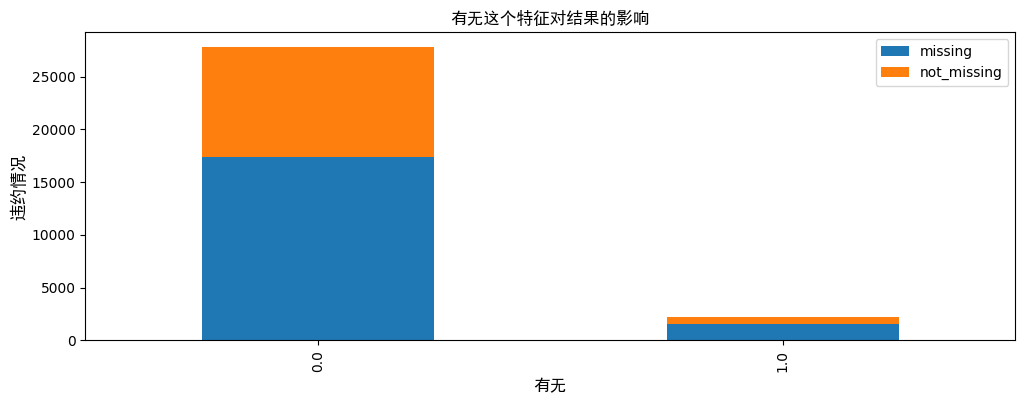

In [70]:
## 处理UserInfo_12缺失
print(master['UserInfo_12'].unique())
#fig = plt.figure()
#fig.set(alpha=0.2)
target_UserInfo_12_not = master.target[master.UserInfo_12.isnull()].value_counts()
target_UserInfo_12_ = master.target[master.UserInfo_12.notnull()].value_counts()
df_UserInfo_12 = pd.DataFrame({'missing': target_UserInfo_12_not, 'not_missing': target_UserInfo_12_})
df_UserInfo_12
df_UserInfo_12.plot(kind='bar', stacked=True)
plt.title(u'有无这个特征对结果的影响', fontproperties=myfont)
plt.xlabel(u'有无', fontproperties=myfont)
plt.ylabel(u'违约情况', fontproperties=myfont)
plt.show()

In [71]:
master.loc[(master.UserInfo_12.isnull(), 'UserInfo_12')] = 2.0
#train_master['UserInfo_11'].fillna(2.0)
#train_master['UserInfo_12'] =train_master['UserInfo_12'].astype(np.int32)
print(master['UserInfo_12'].dtypes)
print(master['UserInfo_12'].unique())

float64
[2. 0. 1.]


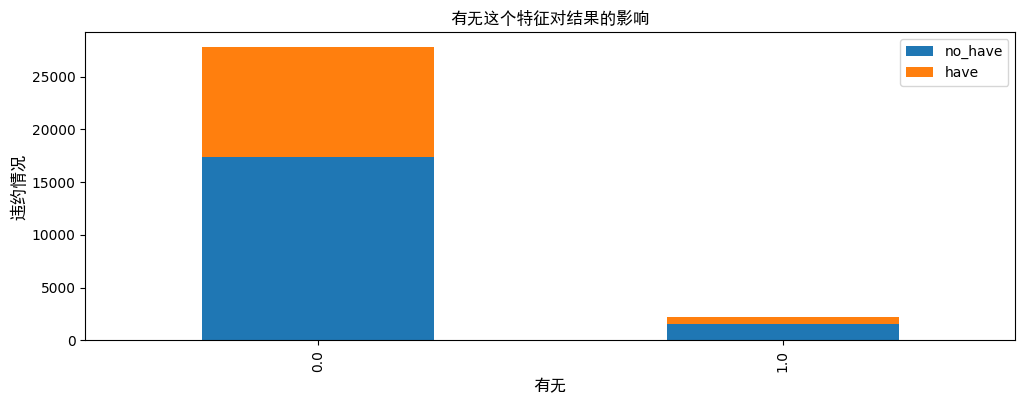

In [72]:
## 处理UserInfo_11缺失
master['UserInfo_11'].unique()
#fig = plt.figure()
#fig.set(alpha=0.2)
target_UserInfo_11_not = master.target[master.UserInfo_11.isnull()].value_counts()
target_UserInfo_11_ = master.target[master.UserInfo_11.notnull()].value_counts()
df_UserInfo_11 = pd.DataFrame({'no_have': target_UserInfo_11_not, 'have': target_UserInfo_11_})
df_UserInfo_11.plot(kind='bar', stacked=True)
plt.title(u'有无这个特征对结果的影响', fontproperties=myfont)
plt.xlabel(u'有无', fontproperties=myfont)
plt.ylabel(u'违约情况', fontproperties=myfont)
plt.show()

In [73]:
#train_master['UserInfo_11'] =train_master['UserInfo_11'].astype(str)
master.loc[(master.UserInfo_11.isnull(), 'UserInfo_11')] = 2.0
master['UserInfo_11'].unique()

array([2., 0., 1.])

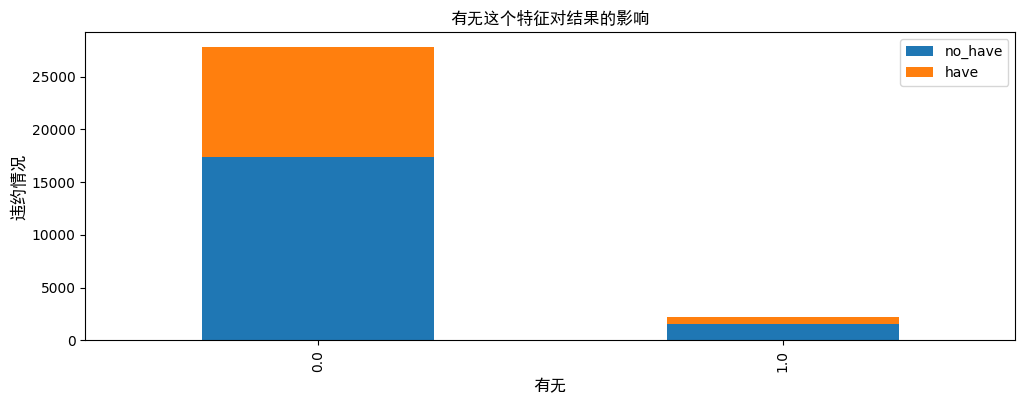

In [74]:
## 处理UserInfo_13缺失
master['UserInfo_13'].unique()
#fig = plt.figure()
#fig.set(alpha=0.2)
target_UserInfo_13_not = master.target[master.UserInfo_13.isnull()].value_counts()
target_UserInfo_13_ = master.target[master.UserInfo_13.notnull()].value_counts()
df_UserInfo_13 = pd.DataFrame({'no_have': target_UserInfo_13_not, 'have': target_UserInfo_13_})
df_UserInfo_13
df_UserInfo_13.plot(kind='bar', stacked=True)
plt.title(u'有无这个特征对结果的影响', fontproperties=myfont)
plt.xlabel(u'有无', fontproperties=myfont)
plt.ylabel(u'违约情况', fontproperties=myfont)
plt.show()

In [75]:
#train_master['UserInfo_13'] =train_master['UserInfo_13'].astype(str)
master.loc[(master.UserInfo_13.isnull(), 'UserInfo_13')] = 2.0
master['UserInfo_13'].unique()

array([2., 1., 0.])

['I5' nan 'I4' 'C19' 'I3' 'U' 'C21' 'C20' 'F13' 'C1' 'C11' 'C12' 'C18'
 'C15' 'O' 'C17' 'F12' 'F9' 'C16' 'I10' 'C13' 'F11' 'F16' 'F7' 'C14' 'I6'
 'F14' 'F10' 'C38' 'F15' 'I11' 'I7' 'C39' 'F6' 'F3' 'C32' 'I8' 'F8' 'F4'
 'I2' 'F1' 'I1' 'F27' 'F2']


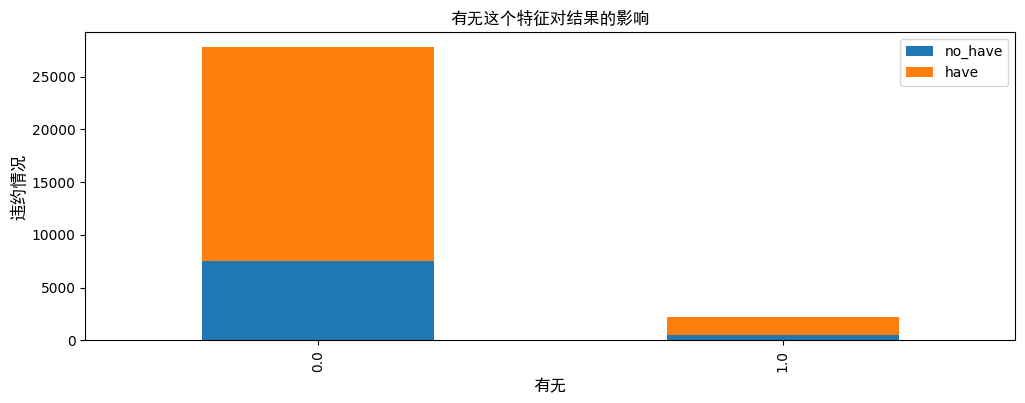

In [76]:
## 处理WeblogInfo_20 缺失
print(master['WeblogInfo_20'].unique())
#fig = plt.figure()
#fig.set(alpha=0.2)
target_WeblogInfo_20_not = master.target[master.WeblogInfo_20.isnull()].value_counts()
target_WeblogInfo_20_ = master.target[master.WeblogInfo_20.notnull()].value_counts()
df_WeblogInfo_20 = pd.DataFrame({'no_have': target_WeblogInfo_20_not, 'have': target_WeblogInfo_20_})
df_WeblogInfo_20
df_WeblogInfo_20.plot(kind='bar', stacked=True)
plt.title(u'有无这个特征对结果的影响', fontproperties=myfont)
plt.xlabel(u'有无', fontproperties=myfont)
plt.ylabel(u'违约情况', fontproperties=myfont)
plt.show()

In [77]:
#train_master['WeblogInfo_20'] =train_master['WeblogInfo_20'].astype(str)
master.loc[(master.WeblogInfo_20.isnull(), 'WeblogInfo_20')] = u'不详'
master['WeblogInfo_20'].unique()

array(['I5', '不详', 'I4', 'C19', 'I3', 'U', 'C21', 'C20', 'F13', 'C1',
       'C11', 'C12', 'C18', 'C15', 'O', 'C17', 'F12', 'F9', 'C16', 'I10',
       'C13', 'F11', 'F16', 'F7', 'C14', 'I6', 'F14', 'F10', 'C38', 'F15',
       'I11', 'I7', 'C39', 'F6', 'F3', 'C32', 'I8', 'F8', 'F4', 'I2',
       'F1', 'I1', 'F27', 'F2'], dtype=object)

['I' 'E' 'F' 'D' 'J' 'G' 'H' '不详']


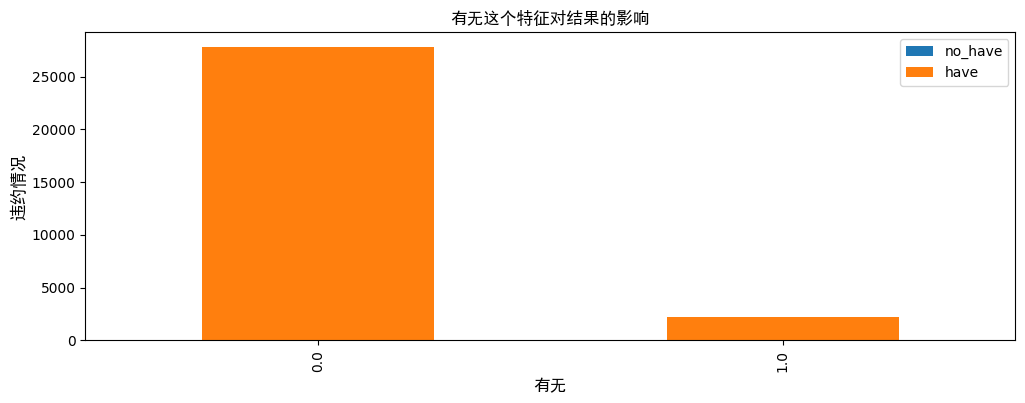

array(['I', 'E', 'F', 'D', 'J', 'G', 'H', '不详'], dtype=object)

In [79]:
print(master['WeblogInfo_19'].unique())
#fig = plt.figure()
#fig.set(alpha=0.2)
target_WeblogInfo_19_not = master.target[master.WeblogInfo_19.isnull()].value_counts()
target_WeblogInfo_19_ = master.target[master.WeblogInfo_19.notnull()].value_counts()
df_WeblogInfo_19 = pd.DataFrame({'no_have': target_WeblogInfo_19_not, 'have': target_WeblogInfo_19_})
df_WeblogInfo_19

df_WeblogInfo_19.plot(kind='bar', stacked=True)
plt.title(u'有无这个特征对结果的影响', fontproperties=myfont)
plt.xlabel(u'有无', fontproperties=myfont)
plt.ylabel(u'违约情况', fontproperties=myfont)
plt.show()

#train_master['WeblogInfo_19'] =train_master['WeblogInfo_19'].astype(str)
master.loc[(master.WeblogInfo_19.isnull(), 'WeblogInfo_19')] = u'不详'
master['WeblogInfo_19'].unique()

['D' 'C' 'A' 'B' nan]


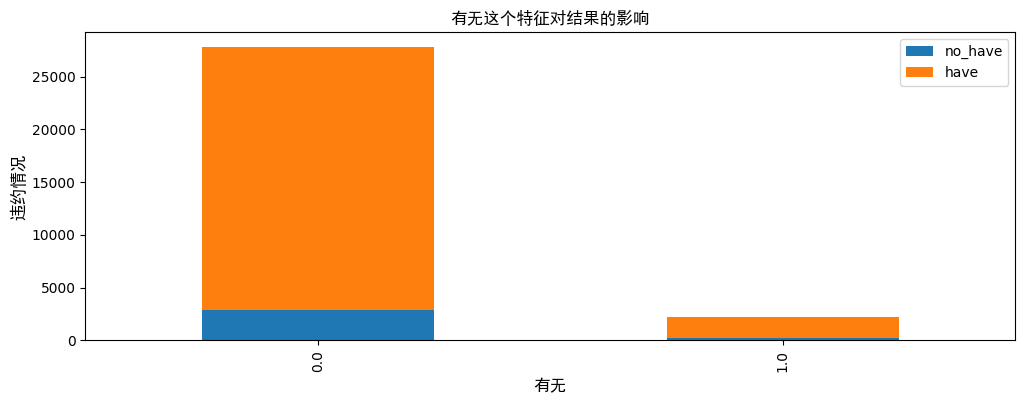

In [80]:
## 处理WeblogInfo_21 缺失
print(master['WeblogInfo_21'].unique())
#fig = plt.figure()
#fig.set(alpha=0.2)
target_WeblogInfo_21_not = master.target[master.WeblogInfo_21.isnull()].value_counts()
target_WeblogInfo_21_ = master.target[master.WeblogInfo_21.notnull()].value_counts()
df_WeblogInfo_21 = pd.DataFrame({'no_have': target_WeblogInfo_21_not, 'have': target_WeblogInfo_21_})
df_WeblogInfo_21

df_WeblogInfo_21.plot(kind='bar', stacked=True)
plt.title(u'有无这个特征对结果的影响', fontproperties=myfont)
plt.xlabel(u'有无', fontproperties=myfont)
plt.ylabel(u'违约情况', fontproperties=myfont)
plt.show()

In [81]:
#train_master['WeblogInfo_21'] =train_master['WeblogInfo_21'].astype(str)
master.loc[(master.WeblogInfo_21.isnull(), 'WeblogInfo_21')] = '0'
master['WeblogInfo_21'].unique()

array(['D', 'C', 'A', 'B', '0'], dtype=object)

**数据预处理与特征工程**

In [20]:
## 其余缺失值很少的就用均值或众数填充
len(master['UserInfo_2'].value_counts())  ## 城市地理位置
len(master['UserInfo_4'].value_counts())  ## 城市地理位置
len(master['UserInfo_8'].value_counts())  ## 城市地理位置
len(master['UserInfo_9'].unique())  ## 城市地理位置
len(master['UserInfo_20'].value_counts())  ## 城市地理位置
len(master['UserInfo_7'].unique())  ## 省份地理位置
len(master['UserInfo_19'].unique())  ## 省份地理位置

# 如果选择以0填充，下述部分就维持现状，如果选择中位数/众数填充，就把下述的部分注释掉
master.loc[(master.UserInfo_2.isnull(), 'UserInfo_2')] = '0'
master.loc[(master.UserInfo_4.isnull(), 'UserInfo_4')] = '0'
master.loc[(master.UserInfo_8.isnull(), 'UserInfo_8')] = '0'
master.loc[(master.UserInfo_9.isnull(), 'UserInfo_9')] = '0'
master.loc[(master.UserInfo_20.isnull(), 'UserInfo_20')] = '0'
master.loc[(master.UserInfo_7.isnull(), 'UserInfo_7')] = '0'
master.loc[(master.UserInfo_19.isnull(), 'UserInfo_19')] = '0'

In [21]:
## 用众数填充缺失值
categoric_cols = ['UserInfo_1', 'UserInfo_2', 'UserInfo_3', 'UserInfo_4', 'UserInfo_5', 'UserInfo_6', 'UserInfo_7',
                  'UserInfo_8', 'UserInfo_9', 'UserInfo_11', 'UserInfo_12', 'UserInfo_13', 'UserInfo_19', 'UserInfo_20',
                  'UserInfo_21', 'UserInfo_22', 'UserInfo_23', 'UserInfo_24', 'Education_Info1', 'Education_Info2',
                  'Education_Info3', 'Education_Info4', 'Education_Info5', 'Education_Info6', 'Education_Info7',
                  'Education_Info8', 'WeblogInfo_19', 'WeblogInfo_20', 'WeblogInfo_21', 'SocialNetwork_1',
                  'SocialNetwork_2', 'SocialNetwork_7', 'SocialNetwork_12']
for col in categoric_cols:
    mode_cols = master[col].mode()[0]
    master.loc[(master[col].isnull(), col)] = mode_cols
## 用均值填充缺失值 
numeric_cols = ['UserInfo_14', 'UserInfo_15', 'UserInfo_16', 'UserInfo_17']
for col in master.columns:
    if col in numeric_cols and col != u'Idx' and col != u'target' and col != 'ListingInfo':
        mean_cols = master[col].mean()
        master.loc[(master[col].isnull(), col)] = mean_cols

y_train = master['target'].values

In [22]:
## 剔除标准差几乎为零的特征项
feature_std = master.std().sort_values(ascending=True)
print(feature_std.head(20))
columns_to_drop = feature_std[(feature_std < 0.1) & (feature_std.index != 'target')].index
master.drop(columns_to_drop, axis=1, inplace=True)
master['Idx'] = master['Idx'].astype(np.int32)

'''
for i in range(25):
    name = 'UserInfo_' + str(i)
    try:
        print(train_master[name].head())
    except:
        pass
'''

WeblogInfo_10      0.000000
WeblogInfo_49      0.008199
WeblogInfo_44      0.016901
WeblogInfo_41      0.022450
WeblogInfo_46      0.030394
WeblogInfo_55      0.033408
WeblogInfo_43      0.036189
SocialNetwork_1    0.037618
WeblogInfo_47      0.040764
WeblogInfo_52      0.048962
WeblogInfo_58      0.059251
WeblogInfo_40      0.068810
WeblogInfo_32      0.080958
WeblogInfo_31      0.082340
WeblogInfo_23      0.093298
WeblogInfo_54      0.099264
WeblogInfo_35      0.101496
WeblogInfo_53      0.109578
WeblogInfo_37      0.110269
WeblogInfo_26      0.114729
dtype: float64


C:\Users\胡逸凡\AppData\Local\Temp\ipykernel_25932\723384064.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  feature_std = master.std().sort_values(ascending=True)


"\nfor i in range(25):\n    name = 'UserInfo_' + str(i)\n    try:\n        print(train_master[name].head())\n    except:\n        pass\n"

In [23]:
import re

## 去掉空格
master['UserInfo_9'] = master['UserInfo_9'].apply(lambda x: x.strip())
## 去掉大小写
userupdateinfo['UserupdateInfo1'] = userupdateinfo['UserupdateInfo1'].apply(lambda x: x.lower())


## 将UserInfo_8中城市名归一化
def encodingstr(s):
    regex = re.compile(r'.+市')
    if regex.search(s):
        s = s[:-1]
        return s
    else:
        return s


def encodingstr2(s):
    special = ['内蒙古自治区', '宁夏回族自治区', '广西壮族自治区', '新疆维吾尔自治区']
    ret = ['内蒙古', '宁夏', '广西', '新疆']
    for i in range(len(special)):
        if s == special[i]:
            return ret[i]
    regex1 = re.compile(r'.+省')
    regex2 = re.compile(r'.+市')
    if regex1.search(s):
        s = s[:-1]
        return s
    elif regex2.search(s):
        s = s[:-1]
        return s
    else:
        return s


print(master['UserInfo_2'].nunique())
print(master['UserInfo_4'].nunique())
print(master['UserInfo_7'].nunique())
print(master['UserInfo_19'].nunique())
print(master['UserInfo_8'].nunique())
print(master['UserInfo_20'].nunique())

master['UserInfo_2'] = master['UserInfo_2'].apply(lambda x: encodingstr(x))
master['UserInfo_4'] = master['UserInfo_4'].apply(lambda x: encodingstr(x))
master['UserInfo_7'] = master['UserInfo_7'].apply(lambda x: encodingstr2(x))
master['UserInfo_19'] = master['UserInfo_19'].apply(lambda x: encodingstr2(x))
master['UserInfo_8'] = master['UserInfo_8'].apply(lambda x: encodingstr(x))
master['UserInfo_20'] = master['UserInfo_20'].apply(lambda x: encodingstr(x))
userupdateinfo.to_csv('./userupdateinfo.csv', index=False, encoding='utf-8')

print(master.columns)

334
335
32
31
675
313
Index(['Idx', 'UserInfo_1', 'UserInfo_2', 'UserInfo_3', 'UserInfo_4',
       'WeblogInfo_2', 'WeblogInfo_4', 'WeblogInfo_5', 'WeblogInfo_6',
       'WeblogInfo_7',
       ...
       'SocialNetwork_11', 'SocialNetwork_12', 'SocialNetwork_13',
       'SocialNetwork_14', 'SocialNetwork_15', 'SocialNetwork_16',
       'SocialNetwork_17', 'target', 'ListingInfo', 'source'],
      dtype='object', length=211)


In [24]:
# feature importances
# x线城市 
def get_city_tier(city):
    first_tier = ['北京', '上海', '广州', '深圳']
    new_first_tier = ['成都', '重庆', '杭州', '武汉', '西安', '郑州', '青岛', '长沙', '天津', '苏州', '南京', '东莞',
                      '沈阳', '合肥', '佛山']
    second_tier = ['昆明', '福州', '无锡', '厦门', '哈尔滨', '长春', '南昌', '济南', '宁波', '大连', '贵阳', '温州',
                   '石家庄', '泉州', '南宁', '金华', '常州', '珠海', '惠州', '嘉兴', '南通', '中山', '保定', '兰州',
                   '台州', '徐州', '太原', '绍兴', '烟台', '廊坊']
    third_tier = ['海口', '汕头', '潍坛', '扬州', '洛阳', '乌鲁木齐', '临沂', '唐山', '镇江', '盐城', '湖州', '赣州',
                  '漳州', '揭阳', '江门', '桂林', '邯郸', '泰州', '济宁', '呼和浩特', '咸阳', '芜湖', '三亚', '阜阳',
                  '淮安', '遵义', '银川', '衡阳', '上饶', '柳州', '淄博', '莆田', '绵阳', '湛江', '商丘', '宜昌',
                  '沧州', '连云港', '南阳', '蚌埠', '驻马店', '滁州', '邢台', '潮州', '秦皇岛', '肇庆', '荆州', '周口',
                  '马鞍山', '清远', '宿州', '威海', '九江', '新乡', '信阳', '襄阳', '岳阳', '安庆', '菏泽', '宜春',
                  '黄冈', '泰安', '宿迁', '株洲', '宁德', '鞍山', '南充', '六安', '大庆', '舟山']
    fourth_tier = ['常德', '渭南', '孝感', '丽水', '运城', '德州', '张家口', '鄂尔多斯', '阳江', '泸州', '丹东', '曲靖',
                   '乐山', '许昌', '湘潭', '晋中', '安阳', '齐齐哈尔', '北海', '宝鸡', '抚州', '景德镇', '延安', '三明',
                   '抚顺', '亳州', '日照', '西宁', '衢州', '拉萨', '淮北', '焦作', '平顶山', '滨州', '吉安', '濮阳',
                   '眉山', '池州', '荆门', '铜仁', '长治', '衡水', '铜陵', '承德', '达州', '邵阳', '德阳', '龙岩',
                   '南平', '淮南', '黄石', '营口', '东营', '吉林', '韶关', '枣庄', '包头', '怀化', '宣城', '临汾',
                   '聊城', '梅州', '盘锦', '锦州', '榆林', '玉林', '十堰', '汕尾', '咸宁', '宜宾', '永州', '益阳',
                   '黔南州', '黔东南', '恩施', '红河', '大理', '大同', '鄂州', '忻州', '吕梁', '黄山', '开封', '郴州',
                   '茂名', '漯河', '葫芦岛', '河源', '娄底', '延边']

    if city in first_tier:
        return 1
    elif city in new_first_tier:
        return 2
    elif city in second_tier:
        return 3
    elif city in third_tier:
        return 4
    elif city in fourth_tier:
        return 5
    elif city == '不详':
        return 6
    return None


city_col = ['UserInfo_2', 'UserInfo_4', 'UserInfo_8', 'UserInfo_20']
for col in city_col:
    master[col] = master[col].apply(get_city_tier)
    mode_value = master[col].mode()[0]
    master[col].fillna(mode_value, inplace=True)
    print(master[col].head(5))

0    1.0
1    3.0
2    4.0
3    5.0
4    4.0
Name: UserInfo_2, dtype: float64
0    1.0
1    3.0
2    4.0
3    5.0
4    4.0
Name: UserInfo_4, dtype: float64
0    1.0
1    3.0
2    4.0
3    5.0
4    4.0
Name: UserInfo_8, dtype: float64
0    4.0
1    6.0
2    4.0
3    6.0
4    5.0
Name: UserInfo_20, dtype: float64


In [25]:
# 是否为**省
my_alpha = 45

province_col = ['UserInfo_7', 'UserInfo_19']
province_info = pd.DataFrame(columns=['Province', 'y_sum', 'num', 'grade'])

co = master['UserInfo_7']
sum_y = master.groupby(co)['target'].sum().reset_index()
num = master.groupby(co).size().reset_index()
province_info['Province'] = master.groupby(co).groups.keys()
province_info['y_sum'] = sum_y['target'].astype(int)
province_info['num'] = num[0].astype(int) 
province_info['grade'] = (province_info['y_sum'] / province_info['num'] * 1000).astype(int)
# province_info['grade'] = province_info['y_sum'] / province_info['num']

In [26]:
filtered_province_info = province_info[province_info['grade'] > my_alpha]
print(filtered_province_info)
province_names = filtered_province_info['Province']
print(province_names)
print(master.shape)
# 遍历每个省份名称，如果 'UserInfo_7' 列的值等于该省份名称，对应列设置为1，否则为0
for col in province_col:
    col = master[col]
    for province in province_names:
        column_name = f'is_{province}'  # 根据省份名称创建列名
        master[column_name] = (col == province).astype(int)

print(master.shape)

   Province  y_sum   num  grade
6        四川    109  2281     47
7        天津     20   377     53
10       山东    228  4094     55
22       湖南    102  2158     47
6     四川
7     天津
10    山东
22    湖南
Name: Province, dtype: object
(60000, 211)
(60000, 215)


In [27]:
for col in province_col:
    col = master[col]
    for i in range(len(col)):
        for j in range(len(province_info)):
            if col[i] == province_info['Province'][j]:
                col[i] = int(province_info['grade'][j])
                break
                
print(master['UserInfo_7'].head())

C:\Users\胡逸凡\AppData\Local\Temp\ipykernel_25932\1764363547.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = int(province_info['grade'][j])


0    37
1    26
2    40
3    28
4    41
Name: UserInfo_7, dtype: object


**建模与特征重要度**

**继续特征工程**

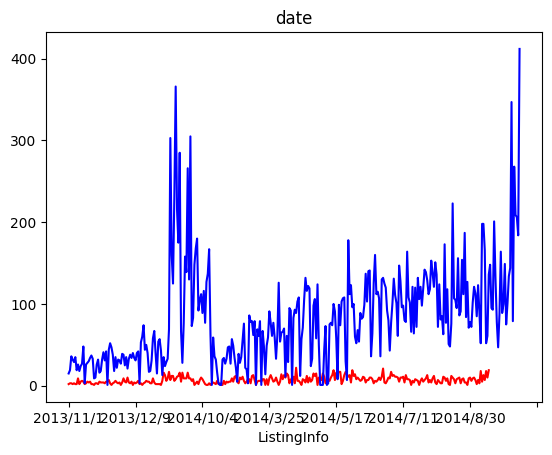

In [28]:
## 借款成交时间处理
grouped_date_1 = master[master.target == 1.0]['target'].groupby(master['ListingInfo']).count()
grouped_date_1.sort_values(ascending=False)
grouped_date_0 = master[master.target == 0.0]['target'].groupby(master['ListingInfo']).count()
grouped_date_0.sort_values(ascending=False)
plt.figure()
plt.title(u'date')
grouped_date_1.plot(color='r')
grouped_date_0.plot(color='b')
plt.show()

In [29]:
## 借款日期离散化
# 把月、日、单独拎出来，放到3列中
master['month'] = pd.DatetimeIndex(master.ListingInfo).month
master['day'] = pd.DatetimeIndex(master.ListingInfo).day
master['day'].head()
master.drop(['ListingInfo'], axis=1, inplace=True)
master['target'] = master['target'].astype(str)
master.to_csv('./master.csv', index=False, encoding='utf-8')

In [30]:
from collections import defaultdict
import datetime as dt

##  userupdateinfo表
userupdate_info_number = defaultdict(list)  ### 用户信息更新的次数
userupdate_info_category = defaultdict(set)  ###用户信息更新的种类数
userupdate_info_times = defaultdict(list)  ### 用户分几次更新了
userupdate_info_date = defaultdict(list)  #### 用户借款成交与信息更新时间跨度

In [31]:
with open('./userupdateinfo.csv', 'r') as f:
    f.readline()
    for line in f.readlines():
        cols = line.strip().split(",")  ### cols 是list结果
        userupdate_info_date[cols[0]].append(cols[1])
        userupdate_info_number[cols[0]].append(cols[2])
        userupdate_info_category[cols[0]].add(cols[2])
        userupdate_info_times[cols[0]].append(cols[3])
    print(u'提取信息完成')

userupdate_info_number_ = defaultdict(int)  ### 用户信息更新的次数
userupdate_info_category_ = defaultdict(int)  ### 用户信息更新的种类数
userupdate_info_times_ = defaultdict(int)  ### 用户分几次更新了
userupdate_info_date_ = defaultdict(int)  #### 用户借款成交与信息更新时间跨度

提取信息完成


In [32]:
for key in userupdate_info_date.keys():
    userupdate_info_times_[key] = len(set(userupdate_info_times[key]))
    delta_date = dt.datetime.strptime(userupdate_info_date[key][0], '%Y/%m/%d') - dt.datetime.strptime(
        list(set(userupdate_info_times[key]))[0], '%Y/%m/%d')
    userupdate_info_date_[key] = abs(delta_date.days)
    userupdate_info_number_[key] = len(userupdate_info_number[key])
    userupdate_info_category_[key] = len(userupdate_info_category[key])

print('信息处理完成')

信息处理完成


In [33]:
## 建立一个DataFrame
Idx_ = list(userupdate_info_date_.keys())  #### list
numbers_ = list(userupdate_info_number_.values())
categorys_ = list(userupdate_info_category_.values())
times_ = list(userupdate_info_times_.values())
dates_ = list(userupdate_info_date_.values())
userupdate_df = pd.DataFrame(
    {'Idx': Idx_, 'numbers': numbers_, 'categorys': categorys_, 'times': times_, 'dates': dates_})
print(userupdate_df.head())
userupdate_df.to_csv('./userupdate_df.csv', index=False, encoding='utf-8')

     Idx  numbers  categorys  times  dates
0  10001       11         10      1     13
1  10002       21         15      3    233
2  10003       10          9      1      8
3  10006       10          9      1      5
4  10007       10         10      2      7


（省略LogInfo表的处理）

**建模调参与优化**

In [34]:
master = pd.read_csv('./master.csv', encoding='utf-8')
userupdateinfo = pd.read_csv('./userupdate_df.csv', encoding='utf-8')

C:\Users\胡逸凡\AppData\Local\Temp\ipykernel_25932\3706582487.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  master = pd.read_csv('./master.csv', encoding='utf-8')


In [35]:
all = pd.merge(master, userupdateinfo, how='left', on='Idx')
all.isnull().sum().sort_values(ascending=False).head(10)

print(all.shape)

(60000, 220)


In [36]:
## 填充缺失值
## 用均值填充缺失值 
numeric_cols = ['dates', 'times', 'categorys', 'numbers']
for col in all.columns:
    if col in numeric_cols and col != u'Idx' and col != u'target' and col != 'ListingInfo':
        mean_cols = all[col].mean()
        all.loc[(all[col].isnull(), col)] = mean_cols

In [37]:
## 对数值型特征进行scaling
import warnings

warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numeric_features = all.select_dtypes(include=['float64', 'int64'])
numeric_features = numeric_features.drop(columns=['Idx'])
all[numeric_features.columns] = scaler.fit_transform(all[numeric_features.columns])
print(all.shape)

(60000, 220)


In [38]:
all['Idx'] = all['Idx'].astype(np.int64)
all['target'].fillna(0, inplace=True)
all['target'] = all['target'].astype(np.int64)
all = pd.get_dummies(all)
all.to_csv('./all.csv', encoding='utf-8', index=False)

print(all.shape)

(60000, 4040)


In [39]:
'''
print('target' in all.columns)
allidx = all['target']
all = all.loc[:, (all == 0).sum() <= 60000]
print('target' in all.columns)
if not 'target' in all.columns:
    all.insert(0, 'target', allidx)  # 重新插入Idx列
print('target' in all.columns)
print(all.shape)
'''

"\nprint('target' in all.columns)\nallidx = all['target']\nall = all.loc[:, (all == 0).sum() <= 60000]\nprint('target' in all.columns)\nif not 'target' in all.columns:\n    all.insert(0, 'target', allidx)  # 重新插入Idx列\nprint('target' in all.columns)\nprint(all.shape)\n"

In [40]:
train_data = all[all['source_test'] == False]
test_data = all[all['source_test'] == True]
train_data.drop(['source_test','source_train'],axis=1,inplace=True)
test_data.drop(['source_test','source_train'],axis=1,inplace=True)
print(test_data.shape)
print(train_data.shape)
y_train = train_data['target']
test_data.drop(['target'], axis=1, inplace=True)
train_data.drop(['target'], axis=1, inplace=True)
print(test_data.shape)
print(train_data.shape)

(30000, 4038)
(30000, 4038)
(30000, 4037)
(30000, 4037)


In [41]:


taidx = train_data['Idx']
teidx = test_data['Idx']

# all = all.loc[:, (all == 0).sum() <= 59500]
print(test_data.shape)
print(train_data.shape)


(30000, 4037)
(30000, 4037)


100

关于现在这个模型
准确率 : 0.9282
AUC 得分 (训练集): 0.999804
f21     1457.0
f31     1416.0
f198    1311.0
f89     1178.0
f59     1151.0
f77     1126.0
f79     1121.0
f62     1119.0
f202    1074.0
f75     1065.0
f72     1064.0
f5      1039.0
f123    1029.0
f76     1018.0
f8      1010.0
f63     1007.0
f106    1001.0
f80      996.0
f61      993.0
f58      984.0
dtype: float64
(303,)


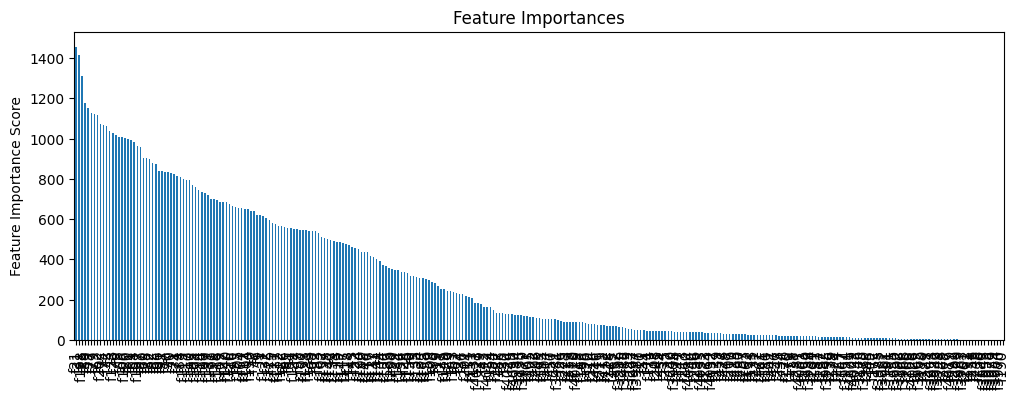

In [42]:

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import metrics
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 12, 4


def modelfit(alg, dtrain, y_train, dtest=None, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values[:, 1:], label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    #建模
    alg.fit(dtrain.values[:, 1:], y_train, eval_metric='auc')

    #对训练集预测
    dtrain_predictions = alg.predict(dtrain.values[:, 1:])
    dtrain_predprob = alg.predict_proba(dtrain.values[:, 1:])[:, 1]

    #输出模型的一些结果
    #print(dtrain_predictions)
    #print(alg.predict_proba(dtrain.as_matrix()[: ,1:]))
    print(cvresult.shape[0])
    print("\n关于现在这个模型")
    print("准确率 : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print("AUC 得分 (训练集): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    print(feat_imp.head(20))
    print(feat_imp.shape)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return feat_imp


xgb1 = XGBClassifier(
    learning_rate=0.01,  # 学习率，一般取值范围在0.01到0.2之间
    n_estimators=100,  # 弱分类器的数量，可以根据交叉验证调整
    max_depth=15,  # 每棵树的最大深度，控制树的复杂度
    min_child_weight=0.3,  # 每个子节点中所需的最小样本权重总和
    gamma=0.15,  # 控制叶子节点分裂的程度，一般取值范围在0到1之间
    subsample=0.8,  # 训练数据的子采样比例，一般取值范围在0.5到1之间
    colsample_bytree=0.8,  # 每棵树的特征子采样比例，一般取值范围在0.5到1之间
    objective='binary:logistic',  # 学习任务的目标，二元分类问题使用 'binary:logistic'
    nthread=4,  # 并行线程数，通常设置为CPU的核心数
    scale_pos_weight=1,  # 正负类别权重平衡，处理不平衡的数据集
    seed=27  # 随机种子，用于生成可重复的随机性
)

feature_imp = modelfit(xgb1, train_data, y_train)


In [43]:

colu = train_data.columns
n = len(feature_imp)
top_n_features = feature_imp.index[:n]
top_n_features = [int(feature[1:]) for feature in top_n_features]
top_n_features = colu[top_n_features]
train_subset2 = train_data[top_n_features]
test_subset2 = test_data[top_n_features]
if not 'Idx' in train_subset2.columns:
    train_subset2.insert(0, 'Idx', taidx)  # 重新插入Idx列
if not 'Idx' in test_subset2.columns:
    test_subset2.insert(0, 'Idx', teidx)  # 重新插入Idx列
train_data = train_subset2
test_data = test_subset2
print(test_data.shape)
print(train_data.shape)


(30000, 341)
(30000, 341)


In [44]:
print(top_n_features)

Index(['UserInfo_6', 'UserInfo_17', 'month', 'ThirdParty_Info_Period2_14',
       'ThirdParty_Info_Period1_1', 'ThirdParty_Info_Period2_2',
       'ThirdParty_Info_Period2_4', 'ThirdParty_Info_Period1_4', 'times',
       'ThirdParty_Info_Period1_17',
       ...
       'UserInfo_19_55', 'UserInfo_19_34', 'SocialNetwork_10',
       'UserInfo_24_龙台镇稻花村', 'Education_Info2_B', 'Education_Info8_F',
       'Education_Info4_AE', 'Education_Info4_V', 'Education_Info6_U',
       'SocialNetwork_14'],
      dtype='object', length=303)


In [45]:
'''
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
rf0 = RandomForestClassifier(oob_score=True , random_state =42)
rf0.fit(train_all.values[:,1:] ,y_train)
print(rf0.oob_score_)
y_predprob = rf0.predict_proba(train_all.values[:,1:])[:,1]
print('AUC Score(Train): %f'%metrics.roc_auc_score(y_train , y_predprob))
rf_predictions_df = pd.DataFrame({'ID': train_all['Idx'], 'Prediction': y_predprob})
rf_predictions_df.to_csv('rf_prediction.csv', index=False)
'''

'\nfrom sklearn.ensemble import RandomForestClassifier\nimport warnings\nwarnings.filterwarnings("ignore")\nrf0 = RandomForestClassifier(oob_score=True , random_state =42)\nrf0.fit(train_all.values[:,1:] ,y_train)\nprint(rf0.oob_score_)\ny_predprob = rf0.predict_proba(train_all.values[:,1:])[:,1]\nprint(\'AUC Score(Train): %f\'%metrics.roc_auc_score(y_train , y_predprob))\nrf_predictions_df = pd.DataFrame({\'ID\': train_all[\'Idx\'], \'Prediction\': y_predprob})\nrf_predictions_df.to_csv(\'rf_prediction.csv\', index=False)\n'

In [46]:
'''
import warnings

warnings.filterwarnings("ignore")
lr = LogisticRegression(tol=1e-6)
parameters = {'penalty': ('l1', 'l2'), 'C': [0.01, 0.1, 1, 10, 100]}
clf_lr = GridSearchCV(lr, parameters, cv=3)
print('开始训练')
clf_lr.fit(train_all.values[:, 1:], y_train)
print('模型训练结束')
print(clf_lr)
'''

'\nimport warnings\n\nwarnings.filterwarnings("ignore")\nlr = LogisticRegression(tol=1e-6)\nparameters = {\'penalty\': (\'l1\', \'l2\'), \'C\': [0.01, 0.1, 1, 10, 100]}\nclf_lr = GridSearchCV(lr, parameters, cv=3)\nprint(\'开始训练\')\nclf_lr.fit(train_all.values[:, 1:], y_train)\nprint(\'模型训练结束\')\nprint(clf_lr)\n'

In [47]:
'''
import warnings

warnings.filterwarnings("ignore")
clf_lr_accuracy = clf_lr.score(train_all.values[:, 1:], y_train)
print(clf_lr_accuracy)
clf_lr.cv_results_, clf_lr.best_params_, clf_lr.best_score_
'''

'\nimport warnings\n\nwarnings.filterwarnings("ignore")\nclf_lr_accuracy = clf_lr.score(train_all.values[:, 1:], y_train)\nprint(clf_lr_accuracy)\nclf_lr.cv_results_, clf_lr.best_params_, clf_lr.best_score_\n'

In [48]:
duplicated_columns = train_data.columns[train_data.columns.duplicated()]
print("重复的列：", duplicated_columns)
train_data = train_data.loc[:, ~train_data.columns.duplicated()]
print(train_data.shape)

duplicated_columns = test_data.columns[test_data.columns.duplicated()]
print("重复的列：", duplicated_columns)
test_data = test_data.loc[:, ~test_data.columns.duplicated()]
print(test_data.shape)

重复的列： Index(['UserInfo_19_53', 'UserInfo_19_39', 'UserInfo_19_32', 'UserInfo_19_38',
       'UserInfo_19_42', 'UserInfo_19_40', 'UserInfo_19_35', 'UserInfo_19_37',
       'UserInfo_19_27', 'UserInfo_19_30', 'UserInfo_19_24', 'UserInfo_19_25',
       'UserInfo_19_34', 'UserInfo_19_28', 'UserInfo_19_39', 'UserInfo_19_39',
       'UserInfo_19_7', 'UserInfo_19_42', 'UserInfo_19_42', 'UserInfo_19_28',
       'UserInfo_19_28', 'UserInfo_19_37', 'UserInfo_19_37', 'UserInfo_19_26',
       'UserInfo_19_35', 'UserInfo_19_35', 'UserInfo_19_20', 'UserInfo_19_26',
       'UserInfo_19_26', 'UserInfo_19_32', 'UserInfo_19_32', 'UserInfo_19_24',
       'UserInfo_19_24', 'UserInfo_19_53', 'UserInfo_19_53', 'UserInfo_19_40',
       'UserInfo_19_40', 'UserInfo_19_47', 'UserInfo_19_27', 'UserInfo_19_27',
       'UserInfo_19_25', 'UserInfo_19_25', 'UserInfo_19_30', 'UserInfo_19_30',
       'UserInfo_19_41', 'UserInfo_19_47', 'UserInfo_19_47', 'UserInfo_19_38',
       'UserInfo_19_38', 'UserInfo_19_55', 'Use

In [49]:
print(train_data.shape)

(30000, 286)


In [50]:
# lightgbm
from lightgbm import LGBMClassifier
from sklearn import metrics

lgb_model = LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=42,
    max_depth=15,
    learning_rate=0.01,
    n_estimators=1000,
    objective='binary', 
    min_split_gain=0.01,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.4,
    reg_lambda=0.4,
    random_state=25,
    cat_smooth=1,
    max_bin=25
)

print(train_data.shape, ' ', len(y_train), ' ', test_data.shape)
lgb_model.fit(train_data.values[:, 1:], y_train, eval_metric='auc')

(30000, 286)   30000   (30000, 286)
[LightGBM] [Info] Number of positive: 2198, number of negative: 27802
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3977
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 266
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073267 -> initscore=-2.537560
[LightGBM] [Info] Start training from score -2.537560


LGBMClassifier(cat_smooth=1, learning_rate=0.01, max_bin=25, max_depth=15,
               min_split_gain=0.01, n_estimators=1000, num_leaves=42,
               objective='binary', random_state=25, reg_alpha=0.4,
               reg_lambda=0.4)

In [51]:
from sklearn import metrics
alg = lgb_model
dtrain = train_data

dtrain_predictions = alg.predict(dtrain.values[:, 1:])
dtrain_predprob = alg.predict_proba(dtrain.values[:, 1:])[:, 1]

dtrain_predictions_df = pd.DataFrame({'Idx': dtrain['Idx'], 'Predicted': dtrain_predprob})
dtrain_predictions_df.to_csv('1.csv', index=False)

dtrain_predictions_df2 = pd.DataFrame({'Idx': dtrain['Idx'], 'Predicted': dtrain_predictions})
dtrain_predictions_df2.to_csv('2.csv', index=False)

print((dtrain_predprob > 0.5).sum())
print((dtrain_predictions == 1).sum())

p = 0
for i in range(len(dtrain_predictions)):
    if y_train[i] == 1 and dtrain_predictions[i] == y_train[i]:
        p += 1
print("\n正确的正确预测数  ", p)

print("关于现在这个模型")
print("准确率 : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
print("AUC 得分 (训练集): %f\n" % metrics.roc_auc_score(y_train, dtrain_predprob))

462
462

正确的正确预测数   460
关于现在这个模型
准确率 : 0.942
AUC 得分 (训练集): 0.989258


In [52]:
#对训练集预测
alg = lgb_model
dtest = test_data
print(dtest.shape)

dtest_predictions = alg.predict(dtest.values[:, 1:])
dtest_predprob = alg.predict_proba(dtest.values[:, 1:])[:, 1]

# 将测试集预测结果保存为CSV文件
dtest_predictions_df = pd.DataFrame({'ID': dtest['Idx'], 'Prediction': dtest_predprob})
dtest_predictions_df.to_csv('lgb_test_predictions.csv', index=False)

dtest_predictions_df2 = pd.DataFrame({'ID': dtest['Idx'], 'Prediction': dtest_predictions})
dtest_predictions_df2.to_csv('lgb_test_predictions2.csv', index=False)

print((dtest_predprob > 0.5).sum())
print((dtest_predictions == 1).sum())

(30000, 286)
68
68


In [53]:
def modeltest(alg, dtrain, y_train, dtest, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values[:, 1:], label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    #建模
    alg.fit(dtrain.values[:, 1:], y_train, eval_metric='auc')

In [54]:
xgb1 = XGBClassifier(
    learning_rate=0.05,  # 学习率，一般取值范围在0.01到0.2之间
    n_estimators=200,  # 弱分类器的数量，可以根据交叉验证调整
    max_depth=7,  # 每棵树的最大深度，控制树的复杂度
    min_child_weight=1,  # 每个子节点中所需的最小样本权重总和
    gamma=0.15,  # 控制叶子节点分裂的程度，一般取值范围在0到1之间
    subsample=0.8,  # 训练数据的子采样比例，一般取值范围在0.5到1之间
    colsample_bytree=0.8,  # 每棵树的特征子采样比例，一般取值范围在0.5到1之间
    objective='binary:logistic',  # 学习任务的目标，二元分类问题使用 'binary:logistic'
    nthread=4,  # 并行线程数，通常设置为CPU的核心数
    scale_pos_weight=3,  # 正负类别权重平衡，处理不平衡的数据集
    seed=42  # 随机种子，用于生成可重复的随机性
)

print(train_data.shape, ' ', len(y_train), ' ', test_data.shape)
# modeltest(xgb1, train_subset_2, y_train_2, test_subset)
# modeltest(xgb1, X_train, y_train, test_subset)
modeltest(xgb1, train_data, y_train, test_data)

(30000, 286)   30000   (30000, 286)


In [55]:
alg = xgb1
dtrain = train_data
# dtrain = X_test
#对训练集预测
dtrain_predictions = alg.predict(dtrain.values[:, 1:])
dtrain_predprob = alg.predict_proba(dtrain.values[:, 1:])[:, 1]

dtrain_predictions_df = pd.DataFrame({'Idx': dtrain['Idx'], 'Predicted': dtrain_predprob})
dtrain_predictions_df.to_csv('1.csv', index=False)

dtrain_predictions_df2 = pd.DataFrame({'Idx': dtrain['Idx'], 'Predicted': dtrain_predictions})
dtrain_predictions_df2.to_csv('2.csv', index=False)

print((dtrain_predprob > 0.5).sum())
print((dtrain_predictions == 1).sum())

p = 0
for i in range(len(dtrain_predictions)):
    if y_train[i] == 1 and dtrain_predictions[i] == y_train[i]:
        p += 1
print("\n正确的正确预测数  ", p)

print("关于现在这个模型")
print("准确率 : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
print("AUC 得分 (训练集): %f\n" % metrics.roc_auc_score(y_train, dtrain_predprob))
# target 2198
'''
pca
n=50 710 0.999975  0
'''

1751
1751

正确的正确预测数   1714
关于现在这个模型
准确率 : 0.9826
AUC 得分 (训练集): 0.996718


'\npca\nn=50 710 0.999975  0\n'

In [56]:
#对训练集预测
alg = xgb1
dtest = test_data
print(dtest.shape)

dtest_predictions = alg.predict(dtest.values[:, 1:])
dtest_predprob = alg.predict_proba(dtest.values[:, 1:])[:, 1]

# 将测试集预测结果保存为CSV文件
dtest_predictions_df = pd.DataFrame({'ID': dtest['Idx'], 'Prediction': dtest_predprob})
dtest_predictions_df.to_csv('test_predictions.csv', index=False)

dtest_predictions_df2 = pd.DataFrame({'ID': dtest['Idx'], 'Prediction': dtest_predictions})
dtest_predictions_df2.to_csv('test_predictions2.csv', index=False)

print((dtest_predprob > 0.5).sum())
print((dtest_predictions == 1).sum())

(30000, 286)
356
356
